In [1]:
# ] activate ../ 

In [1]:
using Revise
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using GridInterpolations

using POMDPPolicies

using JLD2
using FileIO
using Reel
using Random
using POMDPs
using POMDPModelTools
using LinearAlgebra

using PedestrianAvoidancePOMDP
using EmergencyBrakingSystem

In [2]:

# 1) choose which algorithm 
#algorithm = "EmergencyBrakingSystem"
algorithm = "PedestrianAvoidancePOMDP"
#algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"


# 2) load policy
policy = load("../policy/policy.jld2")["policy"];
#policy = load("../policy/lateral2_-600.0_0.3_-1.0_-100.0_20.0_10.0_0.95_.jld2")["policy"];
#policy = load("../policy/longitudinal_-600.0_0.4_0.0_0.0_30.0_0.0_0.95_.jld2")["policy"];


# Definition ego vehicle and pedestrian behavior
scenarios = ["CPCN", "CPAN25", "CPAN75", "CPFA", "FP"]
vut_speeds = [10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]
vut_speeds = vut_speeds / 3.6
hit_points = [0., 10., 20., 30., 40., 50.]

ego_v = vut_speeds[9]
hit_point = hit_points[2]

# 3) choose scenario, 1 -> scenerio with obstruction, 2 -> without obstruction
scenario = scenarios[2]

# 4) if no pedesstrian should be visible
#hit_point = 800.

probability_pedestrian_birth = policy.pomdp.PROBABILITY_PEDESTRIAN_BIRTH


ego_vehicle = []
ego_a = [] 
collision = []
belief = []
action_pomdp = []
collision_rate = []
ttc = []
risk = []
emergency_brake_request = []
prediction_obstacle = []

### Simulate scenario with parameters above defined
# generate scenario based on scenario type
(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, scenario_id) = PedestrianAvoidancePOMDP.generate_scenario(scenario, ego_v, hit_point)
#println(ego_x, " ", ego_y, " ", ego_v, " ", ped_x," ",  ped_y," ",  ped_v)

# simulate scenario
if (algorithm == "EmergencyBrakingSystem")
    (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = EmergencyBrakingSystem.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles)
else
    (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth, [0.0])
end
#evaluate result
(collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenarioMetric(ego_vehicle, emergency_brake_request, ego_a, collision, ped_x)



PedestrianAvoidancePOMDP


(false, false, 0.0, 6.943434343434337, -3.3333333333333335, 49.0, -4.0)

In [3]:
# Visualize scenario
cam = StaticCamera(VecE2(95.0,0.0),15.0)
# cam = CarFollowCamera(1,10.0)

if (algorithm == "EmergencyBrakingSystem")
    duration, fps, render_hist = EmergencyBrakingSystem.animate_record(rec, timestep, env, ego_vehicle, sensor, sensor_observations, risk, ttc, collision_rate, emergency_brake_request, prediction_obstacle, cam)
else
    duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, prediction_obstacle, cam)
end

film = roll(render_hist, fps = fps, duration = duration)
#write("state_space.mp4", film) # Write to a webm video


Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_7F9D.tmp", 0x000000000000003d, 5.0, nothing)

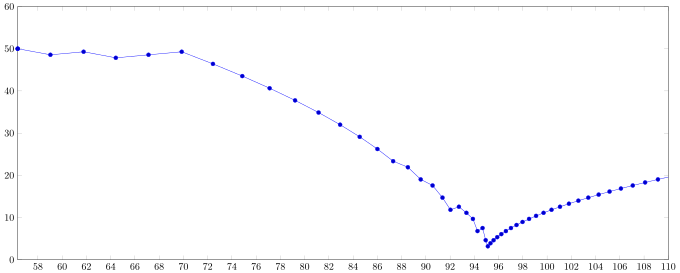

In [7]:
# store and visualize velocity and acceleration profile
using PGFPlots
v = Float64[] 
x = Float64[]
a = Float64[]
push!(v, ego_vehicle[2].state.v)
push!(x, ego_vehicle[2].state.posG.x)
push!(a, ego_a[2])

for i=2:length(ego_vehicle)
    v_tmp = v[end]*0.0 + 1.0*ego_vehicle[i].state.v
    push!(v, v_tmp) 
    push!(x, ego_vehicle[i].state.posG.x)

    push!(a, ego_a[i])
end

file_name = string(algorithm, ".jld2");
@save file_name x v a;

p = PGFPlots.Linear(x, v*3.6)

Axis([
    p
], width=700, height=300, ymin=0, ymax=60, xmin=x[1], xmax=110)



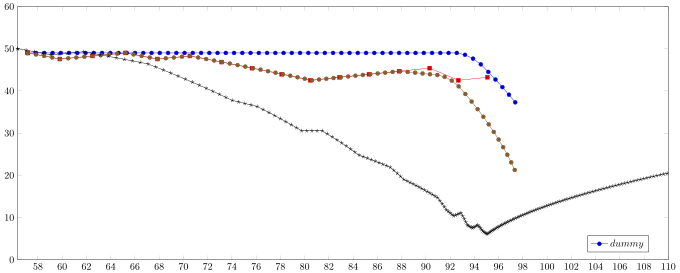

In [6]:
# using Plots
using PGFPlots
# pgfplots()

algorithm = "EmergencyBrakingSystem_CPCN"
file_name = string(algorithm, ".jld2")
@load file_name x v a
p1_v = PGFPlots.Linear(x,v*3.6)
p1_a = PGFPlots.Linear(x,a)


algorithm = "PedestrianAvoidancePOMDP_CPCN"
file_name = string(algorithm, ".jld2")
@load file_name x v a
p2_v = PGFPlots.Linear(x,v*3.6)
p2_a = PGFPlots.Linear(x,a)


algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_CPCN"
file_name = string(algorithm, ".jld2")
@load file_name x v a
p3_v = PGFPlots.Linear(x,v*3.6)
p3_a = PGFPlots.Linear(x,a)

algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_CPCN_no_object"
file_name = string(algorithm, ".jld2")
@load file_name x v a
p4_v = PGFPlots.Linear(x,v*3.6, legendentry=L"$dummy$" )
p4_a = PGFPlots.Linear(x,a)


Axis([
    p1_v,
    p2_v,
    p3_v,
    p4_v
], legendPos="south east", width=700, height=300, ymin=0, ymax=60, xmin=x[1], xmax=110)



In [9]:
# Evaluate EuroNCAP scenarios

using CSV
using DataFrames


# algorithm = "EmergancyBrakingSystem"
algorithm = "PedestrianAvoidancePOMDP"
#algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"

policy_name = "no"
#policy_name = "longitudinal_support"
#policy_name = "longitudinal_lateral_support"
policy = load("../policy/policy.jld2")["policy"];


log_filename = string("results_", algorithm, "_", policy_name, ".csv")

println(log_filename)

scenarios = ["CPCN", "CPAN25", "CPAN75", "CPFA", "FP"]
vut_speeds = [10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]
#vut_speeds = [50.]
vut_speeds = vut_speeds / 3.6

probability_pedestrian_birth = policy.pomdp.PROBABILITY_PEDESTRIAN_BIRTH


println("Algorithm to evaluate: ", algorithm, " Policy: ", policy_name, " (if specified)")

# Evaluate all EuroNCAP scenarios
rec, timestep, env, ego_vehicle, sensor, sensor_observations, risk, ttc, collision_rate, emergency_brake_request, prediction_obstacle, collision, ego_a
results = Vector[]
for scenario in scenarios
    if (scenario == "FP") 
        hit_points = [-100., 200.]
    else
        if (scenario == "CPCN")
            hit_points = [0., 10., 20., 30., 40., 50., 800.] # additional scenario without crossing pedestrian
        else
            hit_points = [0., 10., 20., 30., 40., 50.]
        end
    end
    for hit_point in hit_points
        for vut_speed in vut_speeds
            ego_v = vut_speed
            (ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, scenario_id) = PedestrianAvoidancePOMDP.generate_scenario(scenario, ego_v, hit_point)
            if algorithm == "EmergancyBrakingSystem"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = EmergencyBrakingSystem.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles)
            elseif algorithm == "PedestrianAvoidancePOMDP"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth, [0.0])
            elseif algorithm == "PedestrianAvoidancePOMDP_EmergencyBrakingSystem"
                (rec, timestep, env, sensor, sensor_observations, ego_vehicle, ego_a, collision, belief, action_pomdp, collision_rate, ttc, risk, emergency_brake_request, prediction_obstacle) = PedestrianAvoidancePOMDP.evaluate_scenario(ego_x, ego_y, ego_v, ped_x, ped_y, ped_v, ped_theta, obstacles, policy, algorithm, probability_pedestrian_birth, [0.0])
            else
                println("No valid algorithm defined!")
                return false
            end
            println(scenario, " HP: ", hit_point, " ", ego_x, " ", ego_y, " ", ego_v, " ", ped_x," ",  ped_y," ",  ped_v)
            (collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenarioMetric(ego_vehicle, emergency_brake_request, ego_a, collision, ped_x)
            println("Collision: ", collision, " eb: ", emergency_brake_intervention, " ", dv_collision, " ", v_mean, " ", a_mean, " ", a_jerk, " ", a_min)
            result = [scenario_id, ego_v, hit_point, collision, emergency_brake_intervention, dv_collision, v_mean, a_mean, a_jerk, a_min  ]
            push!(results, result)
        end
    end 
end  


# store results from scneario evaluation in log file
df = DataFrame(results)
df = DataFrame(Matrix(df)')
rename!(df, :x1 => :scenario_id, :x2 => :ego_v, :x3 => :hit_point, :x4 => :collision, :x5 => :eb_intervention)
rename!(df, :x6 => :dv_collision, :x7 => :v_mean, :x8 => :a_mean, :x9 => :a_jerk, :x10 => :a_min)

CSV.write(log_filename, df);

(sum_collisions, sum_eb, dv, v_mean, a_mean, a_jerk, a_min) = PedestrianAvoidancePOMDP.evaluateScenariosMetric(results)

println("#collisions: ", sum_collisions, " #emergency brake interventions: ", sum_eb, " dv_m: ", dv, " v_mean: ", v_mean, " a_mean: ", a_mean, " a_jerk: ", a_jerk, " a_min: ", a_min)

df


results_PedestrianAvoidancePOMDP_no.csv
Algorithm to evaluate: PedestrianAvoidancePOMDP Policy: no (if specified)
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPCN HP: 0.0 89.66666666666667 0.0 2.7777777777777777 100.0 -5.066666666666666 1.3888888888888888
Collision: true eb: false 1.5777777777777784 2.0577777777777784 -2.111111111111111 33.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPCN HP: 0.0 85.5 0.0 4.166666666666667 100.0 -5.066666666666666 1.3888888888888888
Collision: true eb: false 1.3666666666666674 2.9303030303030315 -2.0 37.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPCN HP: 0.0 81.33333333333334 0.0 5.555555555555555 100.0 -5.066666666666666 1.3888888888888888
Collision: true eb: false 1.5555555555555542 3.6888888888888887 -2.0 20.0 -4.0
PedestrianAvoidancePOMDP
CPCN HP: 0.0 77.16666666666666 0.0 6.944444444444445 100.0 -5.066666666666666 1.3888888888888888


PedestrianAvoidancePOMDP
CPCN HP: 30.0 60.5 0.0 12.5 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: false 0.0 6.431249999999997 -3.4444444444444446 21.0 -4.0
PedestrianAvoidancePOMDP
CPCN HP: 30.0 56.33333333333333 0.0 13.88888888888889 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: false 0.0 6.394444444444442 -3.0434782608695654 39.0 -4.0
PedestrianAvoidancePOMDP
CPCN HP: 30.0 52.16666666666667 0.0 15.277777777777777 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: false 0.0 7.232063492063488 -2.92 37.0 -4.0
PedestrianAvoidancePOMDP
CPCN HP: 30.0 48.0 0.0 16.666666666666668 100.0 -4.526666666666666 1.3888888888888888
Collision: false eb: false 0.0 8.172549019607843 -3.2 19.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPCN HP: 40.0 89.66666666666667 0.0 2.7777777777777777 100.0 -4.346666666666666 1.3888888888888888
Collision: true eb: false 1.5777777777777784 2.1077777777777778 -2.28571428571428

CPAN25 HP: 0.0 73.0 0.0 8.333333333333334 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: false 0.0 4.6988505747126394 -3.3846153846153846 37.0 -4.0
PedestrianAvoidancePOMDP
CPAN25 HP: 0.0 68.83333333333334 0.0 9.722222222222221 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: false 0.0 4.855555555555553 -3.0 35.0 -4.0
PedestrianAvoidancePOMDP
CPAN25 HP: 0.0 64.66666666666667 0.0 11.11111111111111 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: false 0.0 5.22539682539682 -3.0 35.0 -4.0
PedestrianAvoidancePOMDP
CPAN25 HP: 0.0 60.5 0.0 12.5 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: false 0.0 6.26363636363636 -3.3157894736842106 35.0 -4.0
PedestrianAvoidancePOMDP
CPAN25 HP: 0.0 56.33333333333333 0.0 13.88888888888889 100.0 -5.066666666666666 1.3888888888888888
Collision: false eb: false 0.0 7.450179211469528 -3.2 41.0 -4.0
PedestrianAvoidancePOMDP
CPAN25 HP: 0.0 52.16666666666667 0.0 15.277777777777777 100.0 -5.06666

PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPAN25 HP: 30.0 48.0 0.0 16.666666666666668 100.0 -4.526666666666666 1.3888888888888888
Collision: true eb: false 9.666666666666663 12.885714285714284 -2.769230769230769 14.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPAN25 HP: 40.0 89.66666666666667 0.0 2.7777777777777777 100.0 -4.346666666666666 1.3888888888888888
Collision: true eb: false 1.3777777777777782 2.4601307189542485 -1.875 25.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPAN25 HP: 40.0 85.5 0.0 4.166666666666667 100.0 -4.346666666666666 1.3888888888888888
Collision: true eb: false 1.5666666666666675 3.2266666666666675 -2.1 26.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPAN25 HP: 40.0 81.33333333333334 0.0 5.555555555555555 100.0 -4.346666666666666 1.3888888888888888
Collision: true eb: false 1.5555555555555554 4.0101010101010

CPAN75 HP: 10.0 68.83333333333334 0.0 9.722222222222221 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: false 0.0 5.335555555555552 -3.2666666666666666 43.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 10.0 64.66666666666667 0.0 11.11111111111111 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: false 0.0 5.56565656565656 -3.2222222222222223 41.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 10.0 60.5 0.0 12.5 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: false 0.0 7.148275862068961 -3.4705882352941178 27.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 10.0 56.33333333333333 0.0 13.88888888888889 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: false 0.0 7.63555555555555 -3.3684210526315788 45.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 10.0 52.16666666666667 0.0 15.277777777777777 100.0 -3.986666666666666 1.3888888888888888
Collision: false eb: false 0.0 8.411111111111104 -3.380952380952381 31.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 H

PedestrianAvoidancePOMDP
CPAN75 HP: 50.0 81.33333333333334 0.0 5.555555555555555 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: false 0.0 3.71388888888889 -2.4545454545454546 27.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 50.0 77.16666666666666 0.0 6.944444444444445 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: false 0.0 4.883574879227053 -3.0 27.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 50.0 73.0 0.0 8.333333333333334 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: false 0.0 4.664367816091953 -2.933333333333333 29.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 50.0 68.83333333333334 0.0 9.722222222222221 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: false 0.0 5.715079365079361 -3.2857142857142856 43.0 -4.0
PedestrianAvoidancePOMDP
CPAN75 HP: 50.0 64.66666666666667 0.0 11.11111111111111 100.0 -3.266666666666666 1.3888888888888888
Collision: false eb: false 0.0 6.748148148148142 -3.3333333333333335 35.0 -4.0
Pedestrian

CPFA HP: 20.0 56.33333333333333 0.0 13.88888888888889 100.0 -7.206666666666667 2.2222222222222223
Collision: false eb: false 0.0 7.944061302681986 -3.3157894736842106 29.0 -4.0
PedestrianAvoidancePOMDP
CPFA HP: 20.0 52.16666666666667 0.0 15.277777777777777 100.0 -7.206666666666667 2.2222222222222223
Collision: false eb: false 0.0 8.122939068100353 -3.1363636363636362 39.0 -4.0
PedestrianAvoidancePOMDP
CPFA HP: 20.0 48.0 0.0 16.666666666666668 100.0 -7.206666666666667 2.2222222222222223
Collision: false eb: false 0.0 10.207407407407405 -3.142857142857143 9.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
CPFA HP: 30.0 89.66666666666667 0.0 2.7777777777777777 100.0 -7.026666666666667 2.2222222222222223
Collision: true eb: false 1.577777777777779 2.3000000000000007 -2.8333333333333335 20.0 -4.0
PedestrianAvoidancePOMDP
CPFA HP: 30.0 85.5 0.0 4.166666666666667 100.0 -7.026666666666667 2.2222222222222223
Collision: false eb: false 0.0 3.1285714285714294 -

-----------------> Collision <----------------------
FP HP: -100.0 73.0 0.0 8.333333333333334 100.0 -6.866666666666666 1.3888888888888888
Collision: true eb: false 1.53333333333333 5.022222222222221 -3.2857142857142856 24.0 -4.0
PedestrianAvoidancePOMDP
FP HP: -100.0 68.83333333333334 0.0 9.722222222222221 100.0 -6.866666666666666 1.3888888888888888
Collision: false eb: false 0.0 10.83650793650793 -1.9285714285714286 83.0 -2.0
PedestrianAvoidancePOMDP
FP HP: -100.0 64.66666666666667 0.0 11.11111111111111 100.0 -6.866666666666666 1.3888888888888888
Collision: false eb: false 0.0 12.12444444444444 -2.125 98.0 -4.0
PedestrianAvoidancePOMDP
-----------------> Collision <----------------------
FP HP: -100.0 60.5 0.0 12.5 100.0 -6.866666666666666 1.3888888888888888
Collision: false eb: false 0.0 12.674999999999995 -1.5714285714285714 15.0 -4.0
PedestrianAvoidancePOMDP
FP HP: -100.0 56.33333333333333 0.0 13.88888888888889 100.0 -6.866666666666666 1.3888888888888888
Collision: false eb: false 

,scenario_id,ego_v,hit_point,collision,eb_intervention,dv_collision,v_mean,a_mean,a_jerk,a_min
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,2.77778,0.0,1.0,0.0,1.57778,2.05778,-2.11111,33.0,-4.0
2,1.0,4.16667,0.0,1.0,0.0,1.36667,2.9303,-2.0,37.0,-4.0
3,1.0,5.55556,0.0,1.0,0.0,1.55556,3.68889,-2.0,20.0,-4.0
4,1.0,6.94444,0.0,0.0,0.0,0.0,4.14444,-2.57143,37.0,-4.0
5,1.0,8.33333,0.0,0.0,0.0,0.0,4.12727,-3.14286,35.0,-4.0
6,1.0,9.72222,0.0,0.0,0.0,0.0,4.84949,-3.33333,25.0,-4.0
7,1.0,11.1111,0.0,0.0,0.0,0.0,5.53535,-3.05556,25.0,-4.0
8,1.0,12.5,0.0,0.0,0.0,0.0,6.23939,-3.44444,21.0,-4.0
9,1.0,13.8889,0.0,0.0,0.0,0.0,6.74771,-2.95652,21.0,-4.0
